In [1]:
!export JAX_ENABLE_X64=True

# Core libraries
import itertools
import os

import h5py

from functools import partial

# JAX imports
import jax

import jax.scipy.optimize as joptimize
import jax.scipy.stats as jstats
import jax.nn as jnn
import jax.numpy as jnp

from jax import grad, vmap, jacfwd

import matplotlib as mpl

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width = 234.8775 # in pt.
width, height = set_size(width, fraction=0.8) # in inch
print(width, height)

fontsize = 9
mpl.rcParams.update({
    "figure.figsize": (width, height), 
    "figure.facecolor": 'white', 
    "figure.edgecolor": 'white',
    "savefig.dpi": 360, 
    "figure.subplot.bottom": 0.5, 
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": fontsize-2,
    "xtick.labelsize": fontsize-2,
    "ytick.labelsize": fontsize-2,
    # tight layout,
    "figure.autolayout": True,
})

import matplotlib.pyplot as plt

# Other imports
import lcdb
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
from scipy.optimize import least_squares, minimize
from scipy.stats import spearmanr, kendalltau
from tqdm.notebook import tqdm

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import check_random_state

2.6 1.6068883707497268


If the spearman rank correlation between $f(s)$ and $f(s_{max})$ is good then we can just use $f(s)$ as a proxy to select $f(s_{max})$.

mean_corr_spearman=0.8741
mean_corr_kendall=0.7727


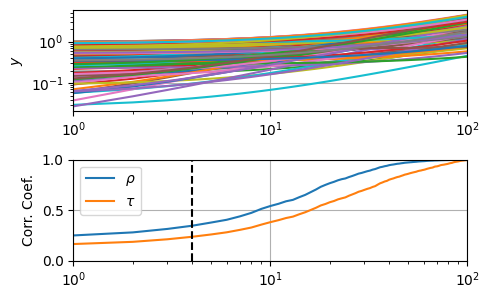

In [9]:
from lcmodel import b_lin2, f_lin2, f_pow3


b = lambda z: b_lin2(z)

f = lambda z, rho: f_lin2(z, b, rho)
nparams = 2

# f = lambda z, rho: f_pow3(z, b, rho)
# nparams = 3

z_range = np.arange(100) + 1
num_models = 100
rs = check_random_state(42)
rho_samples = rs.uniform(low=0, high=1, size=num_models*nparams).reshape(-1, nparams)
rho_samples[:,1] = rho_samples[:,1] * 1/25

y = np.asarray([f(z_range, rho_i) for rho_i in rho_samples])

plt.figure()

plt.subplot(2, 1, 1)

for rho_i in rho_samples:
    plt.plot(z_range, f(z_range, rho_i))

plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.xlim(1, 100)
plt.ylabel(r"$y$")


corr_list_spearman = [spearmanr(y[:,i], y[:,-1])[0] for i in range(len(z_range))]
mean_corr_spearman = np.mean(corr_list_spearman)

# corr_list_kendall = [(kendalltau(y[:,i], y[:,-1])[0]+1)/2 for i in range(len(z_range))]
corr_list_kendall = [(kendalltau(y[:,i], y[:,-1])[0]) for i in range(len(z_range))]
mean_corr_kendall = np.mean(corr_list_kendall)

print(f"{mean_corr_spearman=:.4f}")
print(f"{mean_corr_kendall=:.4f}")

plt.subplot(2, 1, 2)

plt.plot(z_range, corr_list_spearman, label=r"$\rho$")
plt.plot(z_range, corr_list_kendall, label=r"$\tau$")
plt.axvline(x=4, linestyle="--", color="black")
plt.legend()
plt.xscale("log")
plt.grid()
plt.ylim(0,1)
plt.xlim(1, 100)
plt.ylabel("Corr. Coef.")

plt.tight_layout()
plt.savefig("toy_problem_loglin2.png", dpi=360)
plt.show()

After applying the `log` scale on both x and y-axis of the HPOBench curves we notice a linear relation between

\begin{align}
     & \log{y} = \rho_1 \log{b(z)} + \rho_0 \\
\iff & y = z^{\rho_1} \cdot \exp{\rho_0}
\end{align}

where $b(z)$ is the budget allocation scheme based on the current "step" $z$.

A learning curve can be modeled by $f(z;\rho) = y$ where $\rho$ are some parameters of the learning curve model. It can be the union of trainable weights and hyperparameters in the case of neural networks.

We only consider __maximisation__ which equivalent to minimization up to a sign, the mapping of the vocabulary would be:
* (max|min)-(imization|imizing|imum)

---

In the current literature different problems are reusing similar solutions:

**Multi-Fidelity (MF)**

The goal is to use a proxy of the real expensive function to optimize in order to rank candidates.

**Anytime Learning (AL)**

The goal is to maximise the area under learning curve. Therefore we do not want to only select the select the "best" model. But, we want to build a good predictor as early as possible. Of course, multi-fidelity solutions can be used but should be adapted to not only "select/sort" candidates but train them up to a point where they are good for prediction.

---

HERE we must have a way to map the MF problem to an AL problem with an "optimal" policy. Something like "

WHERE do we consider the full budget (parallel|sequential)? A parallel program can be mapped to a sequential problem to use the exact same budget (in term of compute), but the opposite is not always possible. A sequantial algorithm cannot always be divided in parallel ressources.

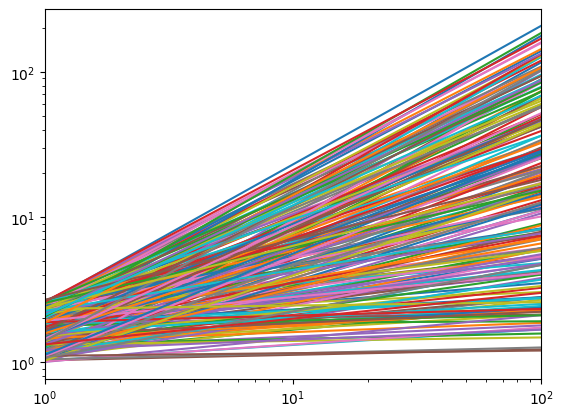

mean_corr=0.7936


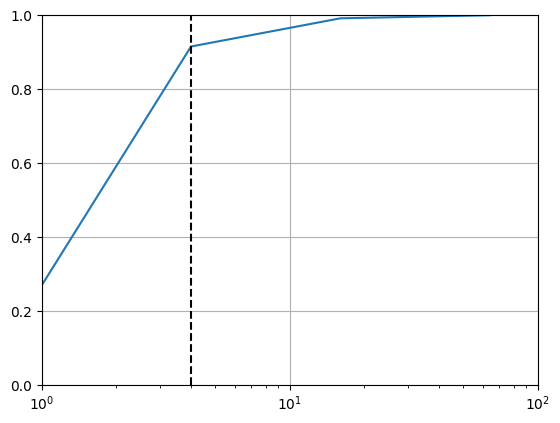

In [37]:
from lcmodel import b_lin2, f_lin2, f_pow3, f_loglin2


b = lambda z: b_lin2(z)

f = lambda z, rho: f_loglin2(z, b, rho)
nparams = 2

z_max = 100
z_range = np.arange(z_max) + 1
num_models = 200
rs = check_random_state(42)
rho_samples = rs.uniform(low=0, high=1, size=num_models*nparams).reshape(-1, nparams)
rho_samples[:,1] = rho_samples[:,1]

y = np.asarray([f(z_range, rho_i) for rho_i in rho_samples])
# noise = rs.normal(0, 1, size=num_models*len(z_range)).reshape(num_models, len(z_range))
# y = y + noise

# print(noise)

plt.figure()

for rho_i in rho_samples:
    plt.plot(z_range, f(z_range, rho_i))

plt.yscale("log")
plt.xscale("log")
plt.xlim(1, z_max)
plt.show()


z_alloc = [1, 4, 16, 64]
corr_list = [spearmanr(y[:,i], y[:,-1])[0] for i in range(len(z_range)) if z_range[i] in z_alloc]
mean_corr = np.mean(corr_list)

print(f"{mean_corr=:.4f}")

plt.figure()
plt.plot(z_alloc, corr_list)
plt.axvline(x=4, linestyle="--", color="black")
plt.xscale("log")
plt.grid()
plt.ylim(0,1)
plt.xlim(1, z_max)
plt.show()

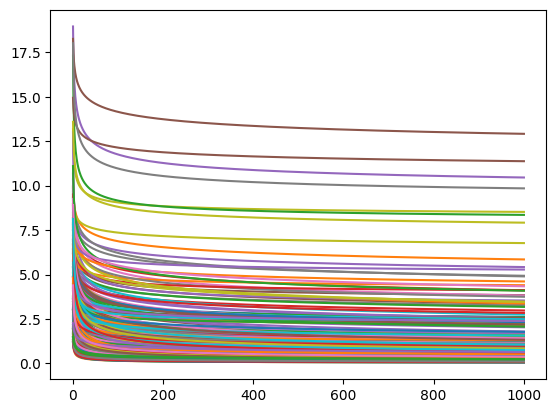

mean_corr=0.9919


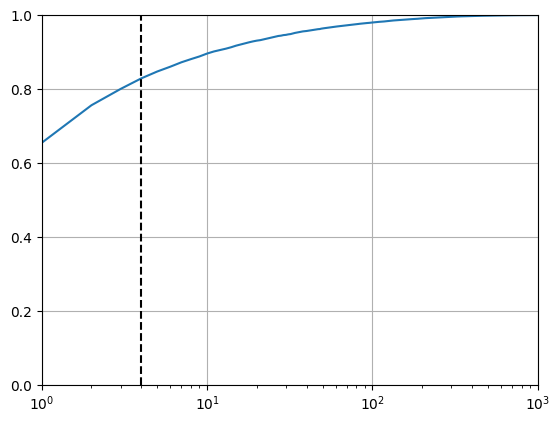

In [33]:
from lcmodel import b_lin2, f_lin2, f_pow3
from deephyper.problem import HpProblem


problem = HpProblem()
problem.add_hyperparameter((1e-6, 10, "log-uniform"), "alpha")
problem.add_hyperparameter((1.0, 10.0), "beta")
problem.add_hyperparameter((0.1, 0.5), "gamma")

# problem.add_hyperparameter((1e-6, 2.0, "log-uniform"), "alpha")
# problem.add_hyperparameter((1.0, 5.0), "beta")
# problem.add_hyperparameter((0.1, 0.3), "gamma")


# default
# problem.add_hyperparameter((1e-5, 2.0, "log-uniform"), "alpha")
# problem.add_hyperparameter((1.0, 10.0), "beta")
# problem.add_hyperparameter((0.1, 0.5), "gamma")

b = lambda z: b_lin2(z)

f = lambda z, rho: f_pow3(z, b, rho)
nparams = 3

z_range = np.arange(1000) + 1
num_models = 200
rs = check_random_state(42)
rho_samples = []
for i in range(num_models):
    config = problem.space.sample_configuration().get_dictionary()
    rho_i = [config["alpha"], -config["beta"], config["gamma"]]
    rho_samples.append(rho_i)
rho_samples = np.asarray(rho_samples)

y = np.asarray([f(z_range, rho_i) for rho_i in rho_samples])

plt.figure()

for rho_i in rho_samples:
    plt.plot(z_range, f(z_range, rho_i))

# plt.yscale("log")
# plt.xscale("log")
plt.show()


corr_list = [spearmanr(y[:,i], y[:,-1])[0] for i in range(len(z_range))]
mean_corr = np.mean(corr_list)

print(f"{mean_corr=:.4f}")

plt.figure()
plt.plot(z_range, corr_list)
plt.axvline(x=4, linestyle="--", color="black")
plt.xscale("log")
plt.grid()
plt.ylim(0,1)
plt.xlim(1, z_range[-1])
plt.show()

mean_corr=0.9714


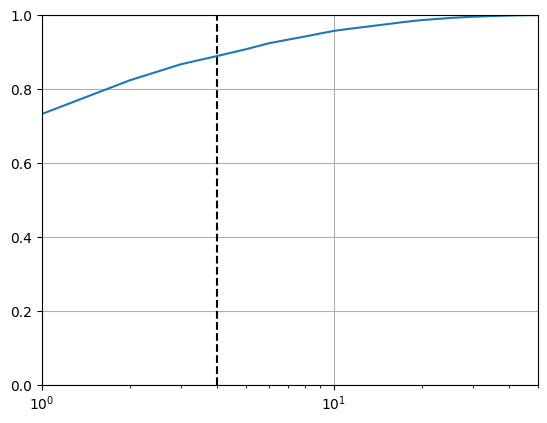

In [45]:
corr_list = [spearmanr(y[:,i], y[:,-1])[0] for i in range(len(z_range))]
mean_corr = np.mean(corr_list)

print(f"{mean_corr=:.4f}")

plt.figure()
plt.plot(z_range, corr_list)
plt.axvline(x=4, linestyle="--", color="black")
plt.xscale("log")
plt.grid()
plt.ylim(0,1)
plt.xlim(1, 50)
plt.show()